Shapefile CRS: EPSG:32640
Number of features in shapefile: 1
Start Point (X, Y in UTM): (673900.8449130745, 4067750.3364529656)
End Point (X, Y in UTM): (758851.4491636921, 4016355.75418502)
Output saved to ./gaz_profile_with_xy.csv


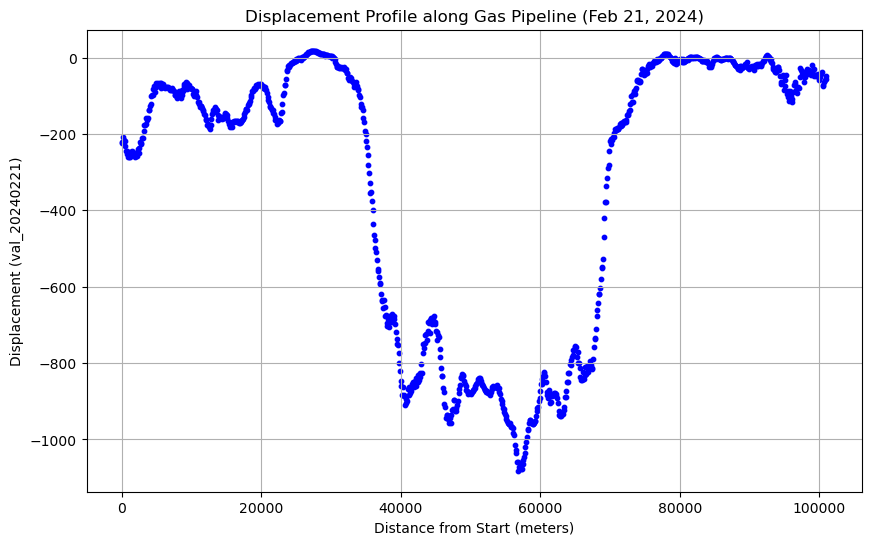

Scatter plot saved to ./displacement_profile.png
Folium map saved to ./gaz_points_map.html

First few rows of the output:
   distance_from_start          X_UTM         Y_UTM  val_20150220  \
0                  0.0  673900.844913  4.067750e+06           0.0   
1                101.0  673976.333254  4.067683e+06           0.0   
2                202.0  674051.821595  4.067616e+06           0.0   
3                303.0  674127.309937  4.067549e+06           0.0   
4                404.0  674209.301485  4.067496e+06           0.0   

   val_20150304  val_20150328  val_20150421  val_20150515  val_20150702  \
0     -5.324095     -4.868188     -0.296555     -2.362778     -2.016812   
1     -5.758978     -5.015368     -0.870419     -2.900439     -3.187123   
2     -5.740386     -4.820266     -0.336265     -2.046074     -1.960537   
3     -5.777077     -4.715535     -0.151976     -2.203882     -2.628910   
4     -5.688233     -4.685218     -0.714450     -2.697275     -2.514925   

   val_20150

In [1]:
import geopandas as gpd
import rasterio
import numpy as np
from shapely.geometry import Point, LineString
import os
import pandas as pd
import matplotlib.pyplot as plt
import folium
from pyproj import Transformer

# Paths
shp_path = "./area/gaz.shp"
raster_dir = "./tiffs_reprojected"
output_path = "./gaz_profile_with_xy.csv"
map_output_path = "./gaz_points_map.html"

# Step 1: Read the shapefile
gdf = gpd.read_file(shp_path)

# Verify CRS
print(f"Shapefile CRS: {gdf.crs}")
if not gdf.crs.is_projected:
    raise ValueError("Shapefile CRS is not projected (UTM). Please reproject to UTM.")

# Check number of features
print(f"Number of features in shapefile: {len(gdf)}")
if len(gdf) != 1:
    print("Warning: Shapefile contains multiple features. Using the first one.")
line = gdf.geometry.iloc[0]  # Assuming the shapefile contains a single line
if not isinstance(line, LineString):
    raise ValueError("Expected a LineString geometry.")

# Step 2: Get start and end points
start_point = line.coords[0]  # First vertex
end_point = line.coords[-1]   # Last vertex
print(f"Start Point (X, Y in UTM): {start_point}")
print(f"End Point (X, Y in UTM): {end_point}")

# Step 3: Generate points along the line at ~101m intervals
line_length = line.length
distances = np.arange(0, line_length, 101)  # 101m intervals
points = [line.interpolate(distance) for distance in distances]

# Step 4: Extract X, Y coordinates for each point
x_coords = [point.x for point in points]
y_coords = [point.y for point in points]

# Step 5: List all raster files
raster_files = [f for f in os.listdir(raster_dir) if f.endswith(".ti.geo.tif")]
raster_files.sort()  # Sort by date

# Step 6: Extract raster values for each point
results = {
    "distance_from_start": distances,
    "X_UTM": x_coords,
    "Y_UTM": y_coords
}
for raster_file in raster_files:
    date = raster_file.split(".")[0]  # Extract date (e.g., 20150220)
    with rasterio.open(os.path.join(raster_dir, raster_file)) as src:
        values = []
        for point in points:
            x, y = point.x, point.y
            try:
                value = next(src.sample([(x, y)]))[0]
                values.append(value if not np.isnan(value) else np.nan)
            except:
                values.append(np.nan)  # Handle cases where point is outside raster
        results[f"val_{date}"] = values

# Step 7: Create a DataFrame and save to CSV
df = pd.DataFrame(results)
df.to_csv(output_path, index=False)
print(f"Output saved to {output_path}")

# Step 8: Scatter Plot (distance_from_start vs val_20240221)
plt.figure(figsize=(10, 6))
plt.scatter(df["distance_from_start"], df["val_20240221"], color="blue", s=10)
plt.xlabel("Distance from Start (meters)")
plt.ylabel("Displacement (val_20240221)")
plt.title("Displacement Profile along Gas Pipeline (Feb 21, 2024)")
plt.grid(True)
plt.savefig("./displacement_profile.png")
plt.show()
print("Scatter plot saved to ./displacement_profile.png")

# Step 9: Folium Map
# Convert UTM (EPSG:32640) to geographic coordinates (EPSG:4326)
transformer = Transformer.from_crs("EPSG:32640", "EPSG:4326", always_xy=True)
lon_lat_points = [transformer.transform(x, y) for x, y in zip(x_coords, y_coords)]

# Convert start and end points to geographic coordinates
start_lon, start_lat = transformer.transform(start_point[0], start_point[1])
end_lon, end_lat = transformer.transform(end_point[0], end_point[1])

# Reproject the line to EPSG:4326 for Folium
gdf_4326 = gdf.to_crs(epsg=4326)
line_4326 = gdf_4326.geometry.iloc[0]

# Create Folium map centered on the mean of the points
mean_lon = np.mean([lon for lon, lat in lon_lat_points])
mean_lat = np.mean([lat for lon, lat in lon_lat_points])
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=10)

# Add the original line
coords = [(y, x) for x, y in line_4326.coords]  # Folium expects (lat, lon)
folium.PolyLine(coords, color="blue", weight=2.5, opacity=1, popup="Gas Pipeline").add_to(m)

# Add all points
for (lon, lat), dist in zip(lon_lat_points, distances):
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color="black",
        fill=True,
        fill_color="black",
        fill_opacity=0.6,
        popup=f"Distance: {dist:.1f} m"
    ).add_to(m)

# Add start and end points
folium.Marker(
    location=[start_lat, start_lon],
    popup="Start Point",
    icon=folium.Icon(color="green", icon="play")
).add_to(m)
folium.Marker(
    location=[end_lat, end_lon],
    popup="End Point",
    icon=folium.Icon(color="red", icon="stop")
).add_to(m)

# Save the map
m.save(map_output_path)
print(f"Folium map saved to {map_output_path}")

# Optional: Print first few rows of the DataFrame
print("\nFirst few rows of the output:")
print(df.head())

In [2]:
m

In [21]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import folium
from pyproj import Transformer
import base64
from io import BytesIO
import rasterio
from folium.raster_layers import ImageOverlay
import numpy.ma as ma

# Paths
shp_paths = {
    "gaz": "./area/gaz.shp",
    "jade": "./area/jade.shp"
}
csv_paths = {
    "gaz": "./gaz_profile_with_xy.csv",
    "jade": "./jade_profile_with_xy.csv"
}
raster_path = "tiffs/20240221.ti.geo.tif"
map_output_path = "./pipelines_map_with_plots_and_raster.html"

# Step 1: Load CSVs and shapefiles
data = {}
for name in ["gaz", "jade"]:
    # Load CSV
    try:
        df = pd.read_csv(csv_paths[name])
        if not all(col in df.columns for col in ["distance_from_start", "X_UTM", "Y_UTM", "val_20240221"]):
            raise ValueError(f"{name} CSV missing required columns")
        print(f"{name} CSV loaded successfully.")
    except Exception as e:
        print(f"Error loading {name} CSV: {e}")
        raise

    # Load shapefile
    try:
        gdf = gpd.read_file(shp_paths[name])
        print(f"{name} Shapefile CRS: {gdf.crs}")
        if not gdf.crs.is_projected:
            raise ValueError(f"{name} Shapefile CRS is not projected (UTM)")
        if len(gdf) != 1:
            print(f"Warning: {name} Shapefile contains multiple features. Using the first one.")
        line = gdf.geometry.iloc[0]
        if not isinstance(line, LineString):
            raise ValueError(f"{name} Expected a LineString geometry")
        print(f"{name} Shapefile loaded successfully.")
    except Exception as e:
        print(f"Error loading {name} shapefile: {e}")
        raise

    # Store data
    data[name] = {"df": df, "gdf": gdf, "line": line}

# Step 2: Get start and end points and convert coordinates
transformer = Transformer.from_crs("EPSG:32640", "EPSG:4326", always_xy=True)
all_lon_lat_points = []
for name in data:
    df = data[name]["df"]
    line = data[name]["line"]
    # Get start and end points
    data[name]["start_point"] = line.coords[0]
    data[name]["end_point"] = line.coords[-1]
    print(f"{name} Start Point (X, Y in UTM): {data[name]['start_point']}")
    print(f"{name} End Point (X, Y in UTM): {data[name]['end_point']}")

    # Convert UTM to geographic coordinates
    data[name]["lon_lat_points"] = [transformer.transform(x, y) for x, y in zip(df["X_UTM"], df["Y_UTM"])]
    data[name]["start_lon"], data[name]["start_lat"] = transformer.transform(data[name]["start_point"][0], data[name]["start_point"][1])
    data[name]["end_lon"], data[name]["end_lat"] = transformer.transform(data[name]["end_point"][0], data[name]["end_point"][1])

    # Reproject line to EPSG:4326
    data[name]["gdf_4326"] = data[name]["gdf"].to_crs(epsg=4326)
    data[name]["line_4326"] = data[name]["gdf_4326"].geometry.iloc[0]

    all_lon_lat_points.extend(data[name]["lon_lat_points"])
print("Coordinates converted to EPSG:4326.")

# Step 3: Create scatter plots with Y=0 line and encode as base64
for name in data:
    df = data[name]["df"]
    plt.figure(figsize=(10, 6))
    plt.scatter(df["distance_from_start"], df["val_20240221"], color="blue", s=10)
    plt.axhline(y=0, color="red", linestyle="--", linewidth=1)  # Add Y=0 line
    plt.xlabel("Distance from Start (meters)")
    plt.ylabel("Displacement 20240221")
    plt.title(f"Displacement Profile along {name.capitalize()} Pipeline (Feb 21, 2024)")
    plt.grid(True)
    buffer = BytesIO()
    plt.savefig(buffer, format="png", bbox_inches="tight")
    plt.close()
    buffer.seek(0)
    plot_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
    data[name]["plot_html"] = f'<img src="data:image/png;base64,{plot_base64}" style="width:600px; height:400px;">'
    print(f"{name} Scatter plot generated and encoded.")

# Step 4: Load and prepare raster with custom colorization
try:
    with rasterio.open(raster_path) as src:
        if src.crs != "EPSG:4326":
            print(f"Warning: Raster CRS is {src.crs}, expected EPSG:4326. Assuming geographic coordinates.")
        raster_data = src.read(1)  # Read first band
        bounds = src.bounds  # Get bounding box
        raster_extent = [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]  # [[min_lat, min_lon], [max_lat, max_lon]]
        # Mask invalid values
        valid_data = ma.masked_invalid(raster_data)
        # Define custom colormap thresholds and colors
        thresholds = [-0.1, 0.1]  # Subsidence (< -0.1), Stable (-0.1 to 0.1), Uplift (> 0.1)
        colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Red, Green, Blue (RGB)
        # Initialize RGBA array
        raster_rgba = np.zeros((*raster_data.shape, 4), dtype=np.uint8)
        # Apply colorization based on thresholds
        raster_rgba[valid_data < thresholds[0]] = (*colors[0], 255)  # Subsidence: Red
        raster_rgba[(valid_data >= thresholds[0]) & (valid_data <= thresholds[1])] = (*colors[1], 255)  # Stable: Green
        raster_rgba[valid_data > thresholds[1]] = (*colors[2], 255)  # Uplift: Blue
        # Set invalid areas to transparent
        raster_rgba[valid_data.mask] = (0, 0, 0, 0)
        print("Raster loaded and colorized successfully.")
except Exception as e:
    print(f"Error loading raster: {e}")
    raise

# Step 5: Create Folium map
mean_lon = np.mean([lon for lon, lat in all_lon_lat_points])
mean_lat = np.mean([lat for lon, lat in all_lon_lat_points])
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=9, tiles="OpenStreetMap", control_scale=True)
print("Folium map initialized.")

# Add Google Hybrid Satellite basemap
google_tiles = "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}"
folium.TileLayer(
    tiles=google_tiles,
    attr="Google",
    name="Google Hybrid Satellite",
    overlay=False,
    control=True
).add_to(m)
print("Google Hybrid Satellite basemap added.")

# Add raster layer

# Step 6: Add pipelines, points, and plots for each dataset
for name in data:
    # Add pipeline and points to the same feature group
    pipeline_group = folium.FeatureGroup(name=f"{name.capitalize()} Pipeline", show=(name == "gaz"))  # Show gaz by default
    # Add pipeline
    coords = [(y, x) for x, y in data[name]["line_4326"].coords]  # Folium expects (lat, lon)
    folium.PolyLine(coords, color="blue" if name == "gaz" else "purple", weight=2.5, opacity=1, popup=f"{name.capitalize()} Pipeline").add_to(pipeline_group)
    # Add points
    for (lon, lat), dist in zip(data[name]["lon_lat_points"], data[name]["df"]["distance_from_start"]):
        folium.CircleMarker(
            location=[lat, lon],
            radius=3,
            color="black" if name == "gaz" else "gray",
            fill=True,
            fill_color="black" if name == "gaz" else "gray",
            fill_opacity=0.6,
            popup=f"Distance: {dist:.1f} m"
        ).add_to(pipeline_group)
    # Add start and end points
    folium.Marker(
        location=[data[name]["start_lat"], data[name]["start_lon"]],
        popup=f"{name.capitalize()} Start Point",
        icon=folium.Icon(color="green", icon="play")
    ).add_to(pipeline_group)
    folium.Marker(
        location=[data[name]["end_lat"], data[name]["end_lon"]],
        popup=f"{name.capitalize()} End Point",
        icon=folium.Icon(color="red", icon="stop")
    ).add_to(pipeline_group)
    pipeline_group.add_to(m)
    print(f"{name} Pipeline, points, and start/end markers added to map.")

    # Add scatter plot as a toggleable popup
    plot_group = folium.FeatureGroup(name=f"{name.capitalize()} Displacement Plot", show=False)
    plot_popup = folium.Popup(data[name]["plot_html"], max_width=650)
    folium.Marker(
        location=[mean_lat, mean_lon],
        popup=plot_popup,
        icon=folium.Icon(icon_color="transparent")  # Invisible marker
    ).add_to(plot_group)
    plot_group.add_to(m)
    print(f"{name} Scatter plot added as toggleable popup.")

# Step 7: Add layer control (expanded by default)
folium.LayerControl(collapsed=False).add_to(m)
print("Layer control added.")

# Step 8: Save the map
m.save(map_output_path)
print(f"Folium map with embedded plots and raster saved to {map_output_path}")

# Optional: Print first few rows of each CSV
for name in data:
    print(f"\nFirst few rows of {name} CSV:")
    print(data[name]["df"].head())

gaz CSV loaded successfully.
gaz Shapefile CRS: EPSG:32640
gaz Shapefile loaded successfully.
jade CSV loaded successfully.
jade Shapefile CRS: EPSG:32640
jade Shapefile loaded successfully.
gaz Start Point (X, Y in UTM): (673900.8449130745, 4067750.3364529656)
gaz End Point (X, Y in UTM): (758851.4491636921, 4016355.75418502)
jade Start Point (X, Y in UTM): (690311.2684731558, 4051047.1748783635)
jade End Point (X, Y in UTM): (721214.7889135986, 4025791.093391342)
Coordinates converted to EPSG:4326.
gaz Scatter plot generated and encoded.
jade Scatter plot generated and encoded.
Raster loaded and colorized successfully.
Folium map initialized.
Google Hybrid Satellite basemap added.
gaz Pipeline, points, and start/end markers added to map.
gaz Scatter plot added as toggleable popup.
jade Pipeline, points, and start/end markers added to map.
jade Scatter plot added as toggleable popup.
Layer control added.
Folium map with embedded plots and raster saved to ./pipelines_map_with_plots_and